## Part 1: Basics of data processing

*by Morgane Desmau & Marco Alsina*

*Last update: May 2021*

The following notebook explains the steps required to create a database in `araucaria`:

1. Read spectra from files.
2. Align spectra.
3. Merge spectra and calibrate reference channel.
4. Create a database with the processed spectra.

### 1. Checking version

It is convenient to first check the version of `araucaria` and its dependencies. In this case we will use the [get_version()](../utils_module.rst#araucaria.utils.get_version) function.

As seen in the output, this tutorial was developed with version 0.1.9 (your version could vary).

In [1]:
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version      : 3.9.4
Numpy version       : 1.20.3
Scipy version       : 1.6.3
Lmfit version       : 1.0.2
H5py version        : 3.2.1
Matplotlib version  : 3.4.2
Araucaria version   : 0.1.9


### 2. Retrieving filepaths

`araucaria` contains spectra from different beamlines as examples and for testing purposes.
The [testdata](../testdata_module.rst) module offers routines to retrieve the respective filepaths.

In this case we will read and process several scans of goethite (an iron oxyhydroxide). Spectra was measured at the Fe K-edge in the P65 beamline of DESY, Hamburg (data kindly provided by Morgane Desmau):

1. 20K_GOE_Fe_K_240.00000.xdi
2. 20K_GOE_Fe_K_240.00001.xdi
3. 20K_GOE_Fe_K_240.00002.xdi
4. 20K_GOE_Fe_K_240.00003.xdi
5. 20K_GOE_Fe_K_240.00004.xdi

We will use the [get_testpath()](../testdata_module.rst#araucaria.testdata.utils.get_testpath) function to construct a list with filepaths to the scan files.

In [2]:
# retrieving filepaths and storing them in a list
from pathlib import Path
from araucaria.testdata import get_testpath

fpaths = []
for i in range(0,5):
    path = get_testpath('20K_GOE_Fe_K_240.0000%i.xdi' % i)
    fpaths.append(path)

# checking that all filepaths are Path classes
all([isinstance(p, Path) for p in fpaths])

True

<div class="alert alert-info">
    
    **Note**
    
    If you prefer to process your own spectra, just modify the list with filepaths to point to the location of your files. 
</div>

### 3. Reading and aligning scans

Once the filepaths have been retrieved we can use the available functions of the [io_read](../io/io_read.rst) module to read them. Since the specra was acquired at the P65 beamline we will be using the [read_p65()](../io/io_read.rst#araucaria.io.io_read.read_p65) function:

- For convenience we will read both the transmission and reference channels of each scan file and store it as a [Group](../main/main_group.rst#araucaria.main.group.Group).
- A single scan (arbitrarily selected) will be used for alignment of the remaining spectra.
- Aligned spectra will be stored together in a [Collection](../main/main_collection.rst#araucaria.main.collection.Collection) and a summary report is printed.

Alignment will be performed with the [align()](../xas/xas_merge.rst#araucaria.xas.merge.align) function. Note that here we explicitly establish an alignment window of -100 eV to 100 eV around the absorption threshold ($E_0$) to perform the alignment.

<div class="alert alert-info">
    
    **Note**
    
    `araucaria` does not impose a preferred order to approach data pre-processing.
    Thus, you could also choose to first calibrate a single scan and then align the remaining scans before merging.
</div>

In [3]:
from araucaria import Collection
from araucaria.io import read_p65
from araucaria.xas import align, merge

# container of data groups
collection = Collection()

# reading a single scan
ref = read_p65(fpaths[0], scan='mu', ref=True)
collection.add_group(ref, tag='merge')

# reading remaining scans and aligning them
for fpath in fpaths[1:]:
    group = read_p65(fpath, scan='mu', ref=True)
    align(group, ref, window=[-100,100])
    collection.add_group(group, tag='merge')

report = collection.summary(optional=['e_offset'])
report.show()

id  dataset                     tag    mode  n  e_offset   
1   20K_GOE_Fe_K_240.00000.xdi  merge  mu    1             
2   20K_GOE_Fe_K_240.00001.xdi  merge  mu    1  0.0225     
3   20K_GOE_Fe_K_240.00002.xdi  merge  mu    1  0.026688   
4   20K_GOE_Fe_K_240.00003.xdi  merge  mu    1  -0.000625  
5   20K_GOE_Fe_K_240.00004.xdi  merge  mu    1  0.0064375  


Note that each [Group](../main/main_group.rst#araucaria.main.group.Group) dataset is added to the [Collection](../main/main_collection.rst#araucaria.main.collection.Collection) with the [add_group()](../main/main_collection.rst#araucaria.main.collection.Collection.add_group) method. This method also allows specification of a `tag` attribute, which is useful to perform joint operations such as merging spectra. Note that the `tag` attributes are included in the summary report.

Note also that the energy offsets after alignment are negligible, so in this case we could merge the scans without alignment.

<div class="alert alert-info">
    
    **Note**
    
    If no `tag` is specified during [add_group()](../main/main_collection.rst#araucaria.main.collection.Collection.add_group), by default it will be assigned `tag='scan'`.
</div>

### 4. Merging scans

Merge is performed with the [merge()](../xas/xas_merge.rst#araucaria.xas.merge.merge) function, which accepts a `taglist`argument to filter which datasets are considered for merging. Since all datasets have the same `tag`, all are considered for the merge.

In [4]:
# merging scans
report, mgroup = merge(collection, taglist=['merge'], name='20K_GOE_Fe_K')
report.show()

id  filename                    mode  e_offset[eV]  e0[eV]  
1   20K_GOE_Fe_K_240.00000.xdi  mu    0             7126.9  
2   20K_GOE_Fe_K_240.00001.xdi  mu    0.0225        7127.2  
3   20K_GOE_Fe_K_240.00002.xdi  mu    0.026688      7127    
4   20K_GOE_Fe_K_240.00003.xdi  mu    -0.000625     7126.9  
5   20K_GOE_Fe_K_240.00004.xdi  mu    0.0064375     7127.2  
------------------------------------------------------------
    20K_GOE_Fe_K                mu    0             7126.7  


### 5. Calibrating the merged scan

After merging we can verify that the energy of the merged reference channel corresponds to the absorption threshold at the Fe K-edge (7112 eV).

By default the [merge()](../xas/xas_merge.rst#araucaria.xas.merge.merge) function reports the merge result on the primary channel (transmission in this case): We can verify the energy of the merged reference channels by requesting it explicitly with the option `only_mu_ref=True`.

In [5]:
# merging only reference scans
report_ref, mgroup_ref = merge(collection, name='20K_GOE_Fe_K_ref', only_mu_ref=True)
report_ref.show()

id  filename                    mode    e_offset[eV]  e0[eV]  
1   20K_GOE_Fe_K_240.00000.xdi  mu_ref  0             7111.5  
2   20K_GOE_Fe_K_240.00001.xdi  mu_ref  0.0225        7111.4  
3   20K_GOE_Fe_K_240.00002.xdi  mu_ref  0.026688      7111.3  
4   20K_GOE_Fe_K_240.00003.xdi  mu_ref  -0.000625     7111.2  
5   20K_GOE_Fe_K_240.00004.xdi  mu_ref  0.0064375     7111.2  
--------------------------------------------------------------
    20K_GOE_Fe_K_ref            mu_ref  0             7111.4  


In this case the merge report for the reference channel returns a value of 7111.4 eV, so lets go ahead and [calibrate()](../xas/xas_merge.rst#araucaria.xas.merge.calibrate) the merged scan.

After calibration we can verify final value of $E_0$ with the [find_e0()](../xas/xas_normalize.rst#araucaria.xas.normalize.find_e0) function.

In [6]:
# calibrating and computing e0 for the merged reference scan.
from numpy import allclose
from araucaria.xas import calibrate, find_e0

e0       = 7112    # Fe K-edge
e_offset = calibrate(mgroup, e0, update=True)
e0_ref   = find_e0(mgroup, use_mu_ref=True)

# printing results
print('energy offset of merge: %1.3f eV' % e_offset)
print('e0 of merged reference: %1.1f eV' % e0_ref)
allclose(e0, e0_ref)

energy offset of merge: 0.595 eV
e0 of merged reference: 7112.0 eV


True

### 6. Plotting merge results

Once the merge is complete, we can provide the merged group and the original collection to the [fig_merge()](../plot_module.rst#araucaria.plot.fig_merge.fig_merge) function in order to visualize the results.
The function accepts a dictionary to set the parameters for the XAFS figures (`fig_pars`) as well as a dictionary to set general figure parameters (`fig_kws`). 

<div class="alert alert-warning">
    
    **Warning**
    
    [fig_merge()](../plot_module.rst#araucaria.plot.fig_merge.fig_merge) also accepts dictionaries to set the normalization and background removal procedures.
    However, note that these dictionaries are for visualization and comparison purposes only, and have no effect on the merge itself.
</div>

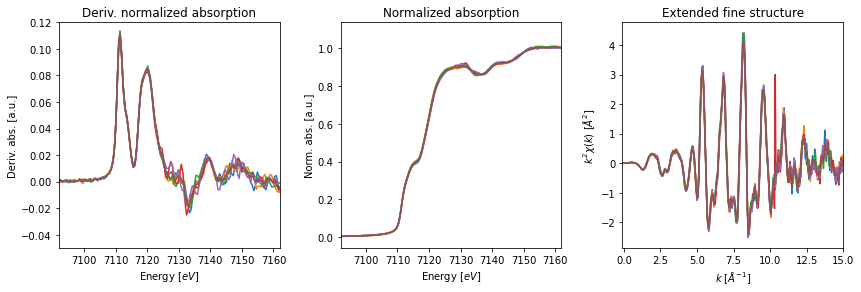

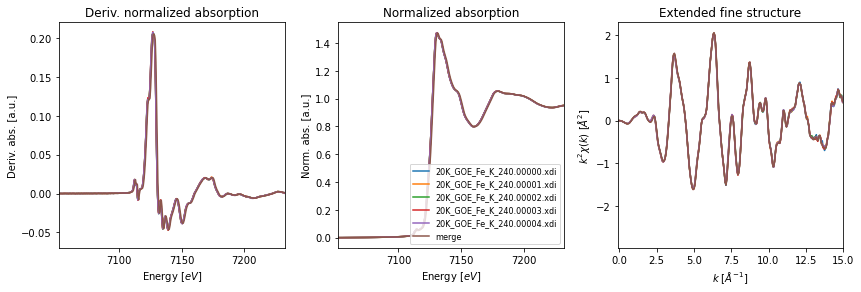

In [7]:
# plot figure of spectra + merge
from araucaria.plot import fig_merge
import matplotlib.pyplot as plt

# general parameters to figure
fig_kws  = {'figsize'  : (12, 4.0)}

# figure parameters for merged reference
fig_pars = {'e_range'  : (e0-20, e0+50),
           'dmu_range' : [-0.05,0.12],
           'k_range'   : [-0.1,15.0],
           'k_mult'    : 2,
           }

# plot of merged reference scans
fig, axes= fig_merge(mgroup_ref, collection, fig_pars=fig_pars, **fig_kws)

# figure parameters for merged scan
fig_pars = {'e_range'  : (e0-60, e0+120),
           'dmu_range' : [-0.07,0.22],
           'k_range'   : [-0.1,15.0],
           'k_mult'    : 2,
           }

# plot of merged scans
fig, axes= fig_merge(mgroup, collection, fig_pars=fig_pars, **fig_kws)
axes[1].legend(fontsize=8)
plt.show()

### 7. Saving datasets in an HDF5 database

If we are satisfied with our results, we can save them in a binary format for later retrieval and analysis.
The [write_collection_hdf5()](../io/io_hdf5.rst#araucaria.io.io_hdf5.write_collection_hdf5) function allows us to directly save a [Collection](../main/main_collection.rst#araucaria.main.collection.Collection) in the Hierarchical Data Format `HDF5`.

In [8]:
from araucaria.io import write_collection_hdf5

collection = Collection()
for group in (mgroup, mgroup_ref):
    collection.add_group(group)

# report for collection
report = collection.summary(optional=['merged_scans'])
report.show()

id  dataset           tag   mode    n  merged_scans                
1   20K_GOE_Fe_K      scan  mu      5  20K_GOE_Fe_K_240.00000.xdi  
                                       20K_GOE_Fe_K_240.00001.xdi  
                                       20K_GOE_Fe_K_240.00002.xdi  
                                       20K_GOE_Fe_K_240.00003.xdi  
                                       20K_GOE_Fe_K_240.00004.xdi  
-------------------------------------------------------------------
2   20K_GOE_Fe_K_ref  scan  mu_ref  5  20K_GOE_Fe_K_240.00000.xdi  
                                       20K_GOE_Fe_K_240.00001.xdi  
                                       20K_GOE_Fe_K_240.00002.xdi  
                                       20K_GOE_Fe_K_240.00003.xdi  
                                       20K_GOE_Fe_K_240.00004.xdi  


In [9]:
# writing collection to HDF5 file
write_collection_hdf5('test_database.h5', collection)

20K_GOE_Fe_K written to test_database.h5.
20K_GOE_Fe_K_ref written to test_database.h5.
